In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


This python file aims to pre-processes the raw dataset used for skin lesion classification. The processing steps are as follows.

1. Resize the images into from (450, 600, 3) to (90, 120, 3)
2. Sample the dataset to make it evenly distributed. The size of the dataset becomes 100 samples x 7 classes
3. Augment the dataset by horizontally flipping each sample, making the size of the dataset 200 samples x 7 classes

Before implementing, remember to change the path based on yours 
:D

In [2]:
import pandas as pd
import cv2
import numpy as np
import csv
import matplotlib.pyplot as plt
import pickle

First, let's look at the distribution of sample categories.

Category  Count Percentage
      nv   6705     66.95%
     mel   1113     11.11%
     bkl   1099     10.97%
     bcc    514      5.13%
   akiec    327      3.27%
    vasc    142      1.42%
      df    115      1.15%


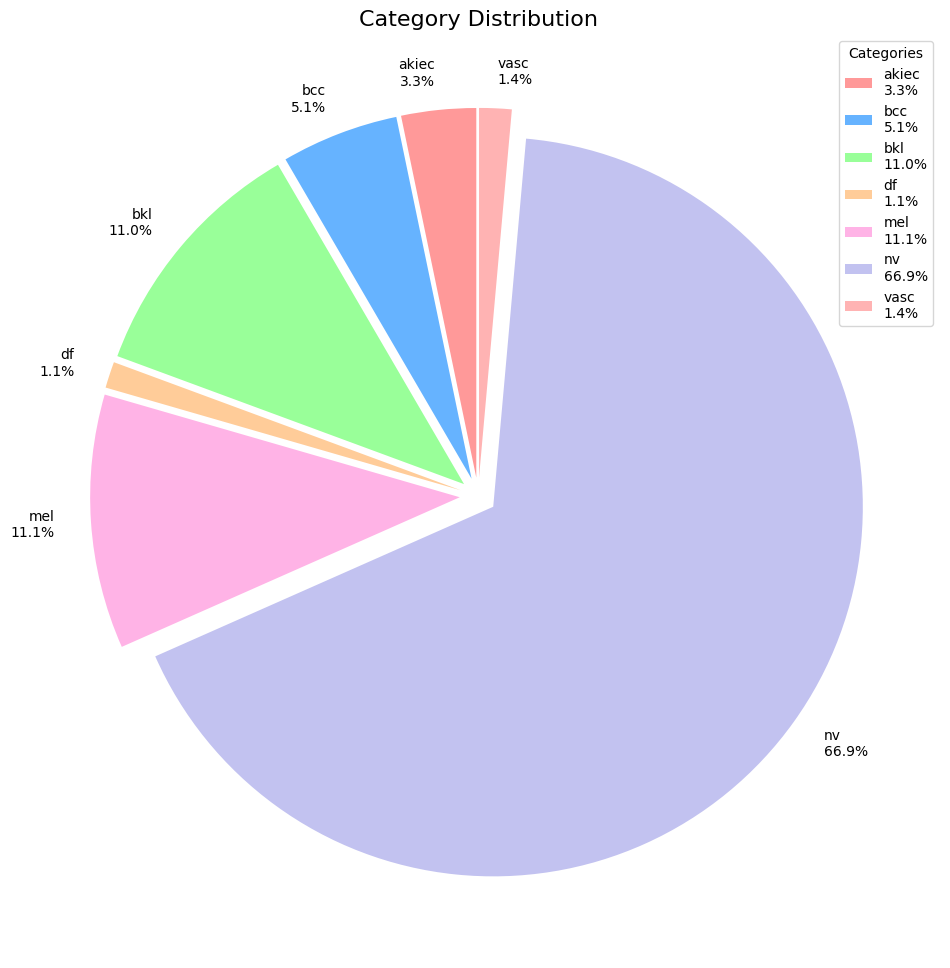

In [4]:
# path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Skin_Lesion_Classification/HAM10000data/'
path = '/content/drive/MyDrive/BME548/'

df = pd.read_csv(path+'HAM10000_metadata.csv')

category_counts = df['dx'].value_counts().sort_index()

# Calculate the percentage of each category
category_percentages = category_counts / category_counts.sum() * 100

# Create a pandas DataFrame with the category counts and percentages
category_table = pd.DataFrame({'Category': category_counts.index, 'Count': category_counts, 'Percentage': category_percentages})

# Sort the table by category count in descending order
category_table = category_table.sort_values('Count', ascending=False)

# Format the Percentage column to include the percentage sign
category_table['Percentage'] = category_table['Percentage'].apply(lambda x: f'{x:.2f}%')

# Print the table with a nice format
print(category_table.to_string(index=False))

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 12))

# Create a list of labels for each category with the percentage value
category_labels = [f"{label}\n{percentage:.1f}%" for label, percentage in zip(category_counts.index, category_percentages)]

# Create a pie chart with custom colors and explode
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ffb3e6','#c2c2f0','#ffb3b3']
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
ax.pie(category_counts, colors=colors, labels=category_labels, startangle=90, explode=explode)

# Add a title
ax.set_title('Category Distribution', fontsize=16)

# Add a legend
ax.legend(title='Categories', loc='upper right')

# Show the plot
plt.show()

In [49]:
def load_metadata(path):
    print("Reading Metadata...")
    metadata = []
    with open(path, 'r') as file:
        reader = csv.reader(file)
        for line in reader:
            metadata.append(line)
    return metadata

def load_dataset(path, metadata):
    print("Loading Dataset...")
    files = []
    labels = []
    counters = {'bkl': 0, 'akiec': 0, 'bcc': 0, 'df': 0, 'mel': 0, 'nv': 0, 'vasc': 0}
    types = {'bkl': 0, 'akiec': 1, 'bcc': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
    # We want to skip the header line, so start from 1
    for i in range(1, len(metadata)):
        label = metadata[i][2]
        # Take 100 Samples from each category
        if counters[label] < 100:
            if metadata[i][1] <= "ISIC_0029305":
                files.append(path + "HAM10000_images_part_1/" + metadata[i][1] + ".jpg")
            else:
                files.append(path + "HAM10000_images_part_2/" + metadata[i][1] + ".jpg")
            labels.append(label)
            counters[label] += 1
        else:            
            pass

    # RESIZE PARAMETER TO BE TUNED
    images = np.zeros((len(files), 150, 200, 3), dtype = float)
    encoded_labels = np.zeros((len(files)), dtype = int)
    # TODO: Use map
    #images = list(map(lambda file: cv2.resize(cv2.imread(file), (200, 150)), files))

    for i, file in enumerate(files):
        # For Progress Visualization
        if (i % 50 == 0):
            print(i, len(files))
        # RESISE PARAMETER TO BE TUNED
        images[i] = normalize(resize(cv2.imread(file), (150, 200)))
        encoded_labels[i] = types[labels[i]]
        
    return images, encoded_labels        
    
def save_tensor(tensor, path):
    with open(path, "wb") as f:
        pickle.dump(tensor, f)
def load_tensor(path):
    with open(path, "rb") as f:        
        tensor = pickle.load(f)
    return tensor
def report_distribution(labels):
    distribution = np.zeros((7), dtype=int)
    for label in labels:
        distribution[label] += 1
    for i, type in enumerate(distribution):
        print('Class {}: {} {} {}%'.format(i, type, sum(distribution), 100 * type/sum(distribution)))

def horizontal_flip(image):
    return cv2.flip(image, 1)
def normalize(image):
    return image / 255
def resize(image, dim):
    # WARNING: cv2 seems to flip width and height
    return cv2.resize(image, (dim[1], dim[0]))
    
def augment_dataset(images, labels):
    print("Augmenting Dataset...")
    n_samples, dim1, dim2, n_channels = images.shape
    augmented_images = np.zeros((2 * n_samples, dim1, dim2, n_channels), dtype=float)
    augmented_labels = np.zeros((2 * n_samples), dtype=int)
    for i in range(n_samples):
        augmented_images[2*i] = images[i]
        augmented_labels[2*i] = labels[i]
        # Where Augmentation Happens
        augmented_images[2*i+1] = horizontal_flip(images[i])
        augmented_labels[2*i+1] = labels[i]
    return augmented_images, augmented_labels

In [50]:
if __name__ == "__main__":
    !ls /content/drive/MyDrive/BME548
    path = '/content/drive/MyDrive/BME548/'
    metadata = load_metadata(path + 'HAM10000_metadata.csv')
    try: # Images may not be dumped yet
        print("Reading Images from dumped dataset (pickle file) ")
        images_path = path + 'images_resized.pickle'
        labels_path = path + 'labels.pickle'

        images = load_tensor(images_path)
        labels = load_tensor(labels_path)
    except: # for the first time
        print("Reading Images from raw dataset")
        images, labels = load_dataset(path, metadata) #load & resize
        save_tensor(images, path + 'images_resized.pickle')
        save_tensor(labels, path + 'labels.pickle')
    print(images.shape, labels.shape)
    report_distribution(labels)
    augmented_images, augmented_labels = augment_dataset(images, labels)
    report_distribution(augmented_labels)

HAM10000_images_part_1	HAM10000_metadata.csv  images_resized.pickle
HAM10000_images_part_2	images		       labels.pickle
Reading Metadata...
Reading Images from dumped dataset 
(700, 150, 200, 3) (700,)
Class 0: 100 700 14.285714285714286%
Class 1: 100 700 14.285714285714286%
Class 2: 100 700 14.285714285714286%
Class 3: 100 700 14.285714285714286%
Class 4: 100 700 14.285714285714286%
Class 5: 100 700 14.285714285714286%
Class 6: 100 700 14.285714285714286%
Augmenting Dataset...
Class 0: 200 1400 14.285714285714286%
Class 1: 200 1400 14.285714285714286%
Class 2: 200 1400 14.285714285714286%
Class 3: 200 1400 14.285714285714286%
Class 4: 200 1400 14.285714285714286%
Class 5: 200 1400 14.285714285714286%
Class 6: 200 1400 14.285714285714286%
